In [ ]:
Студент принёс датасет и предложил посчитать, на catbooste он меня сильно обогнал и добился 84.6% точности предсказания: за
счёт ночного марафона - парень перебрал почти все методы и параметры модели. Меня немного задело что парень так легко меня
обогнал по времени, поэтому я решил обернуть все известные мне модели машинного обучения в функции с набором параметров.

Этот датасет последний, которй попался мне в руки - поэтому здесь и далее я буду использовать его.
Точность предсказания не самоцель - лишь бы функция работала, что не всегда происходит с полпинка.
Процесс фукнционального программирования и тестирования на стыке Python и Pandas - волнителен.

Оборачиваем DecisionTreeClassifier в функцию под pandas.

In [28]:
import pandas as pd
from __future__ import division, print_function
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline
import seaborn as sns
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score

In [19]:
df_2 = pd.read_csv('C:/Users/Battlestation/ML_2018_Edition/Pony_numeric_train.csv', sep=',', encoding='cp1251')
df_2.head()

,win,power_1,power_2,formation_1,formation_2,tactics_1,tactics_2,pressure_1,pressure_2,strategy_1,strategy_2,pass_1,pass_2
0,-1,260.4,261.9,22,13,7,27,True,True,0,0,0,0
1,1,140.3,124.9,12,12,4,3,True,True,0,1,0,0
2,1,122.8,95.3,13,17,21,3,True,True,0,0,0,0
3,1,183.2,63.7,18,12,12,1,True,True,0,0,0,0
4,-1,148.5,107.6,12,13,19,11,True,True,0,3,0,0


In [33]:
df_2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156014 entries, 0 to 156013
Data columns (total 13 columns):
win            156014 non-null int64
power_1        156014 non-null float64
power_2        156014 non-null float64
formation_1    156014 non-null int64
formation_2    156014 non-null int64
tactics_1      156014 non-null int64
tactics_2      156014 non-null int64
pressure_1     156014 non-null bool
pressure_2     156014 non-null bool
strategy_1     156014 non-null int64
strategy_2     156014 non-null int64
pass_1         156014 non-null int64
pass_2         156014 non-null int64
dtypes: bool(2), float64(2), int64(9)
memory usage: 13.4 MB


In [82]:
# работает - не трогай. До сих пор сомневаюсь - не лучше ли вынести это процедуру отдельно от фукнции?
# возможно стоит совместить с перебором и проверкой признаков на принадлежность к bool их их преобразованием.
# вероятно так и поступлю. вопрос пока открыт - преобразование и кодирование отдельно, фукнция модели отдельно?

def warp(df_name, target_name, drop_list=[], *args):
    df_pony = df_name.copy()
    train_df = pd.get_dummies(df_pony, columns=[*args]).drop(drop_list, axis=1)
    target = df_pony[target_name]
    return target

In [83]:
warp(df_2, 'win', ['win'],'formation_1','formation_2','tactics_1','tactics_2','strategy_1','strategy_2')

0        -1
1         1
2         1
3         1
4        -1
5         1
6        -1
7         1
8         1
9        -1
10        1
11        1
12       -1
13        1
14        1
15        1
16       -1
17        1
18       -1
19        1
20       -1
21        1
22        1
23        1
24        1
25        1
26        0
27        1
28       -1
29        1
         ..
155984    1
155985   -1
155986   -1
155987   -1
155988    1
155989    1
155990    1
155991   -1
155992    1
155993    0
155994    1
155995    1
155996    1
155997   -1
155998    0
155999    1
156000    1
156001    0
156002    1
156003    1
156004    1
156005    1
156006   -1
156007    0
156008    1
156009    1
156010   -1
156011    1
156012    0
156013   -1
Name: win, Length: 156014, dtype: int64

In [46]:
# первая версия - в будущем вероятнее всего преобразование bool и кодирование переедет в отдельную фукнцию.

def pony_train(df_name, target_name, drop_list={}, *args):
    """
    Фукнция принимает:
    
    ссылку на датафрейм == df_name
    цель для предсказания == target_name
    список признаков на удаление == drop_list
    список признаков на кодирование == *args
    
    Порядок действий:
    
    1.принимает датафрейм
    2.проводит кодиорование
    3.строит дерево решений по тестовой выборке
    4.проводит кросвалидацию по тестовой выборке
    5.строит дерево по отложенной выборке по лучшим параметрам кроссвалидации
    6.строит дерево по всей выборке по лучшим параметрам кросвалидации и записиывает предикт.
    
    Фукнция возвращает:
    
    1.точность на тестовой выборке.
    2.точность на кроссвалидации.
    3.график оценки кросвалидации.
    4.точность на отложенной выборке по параметрам кросвалидации.
    5.абстракцию с предиктом (датафрейм в котором искомый параметр перезаписан деревом решений)       
    """
    df_pony = df_name.copy()
    train_df = pd.get_dummies(df_pony, columns=[*args]).drop(drop_list, axis=1)
    target = df_pony[target_name]
        
    X_train, X_holdout, y_train, y_holdout = train_test_split(train_df.values, target, test_size=0.3, random_state=17)
    tree = DecisionTreeClassifier(max_depth=3, random_state=17)  
    tree.fit(X_train, y_train)
    tree_pred = tree.predict(X_holdout)
    tree_accuracy = accuracy_score(y_holdout, tree_pred)
    tree_params = {'max_depth': list(range(2, 11))}
    
    tree_grid = GridSearchCV(DecisionTreeClassifier(random_state=17), tree_params, cv=5, scoring='accuracy')
    tree_grid.fit(X_train, y_train)
    grid_score = tree_grid.best_score_   
    grid_params = tree_grid.best_params_
    
    plt.plot(tree_params['max_depth'], 
         tree_grid.cv_results_['mean_test_score'])
    plt.xlabel('Max depth')
    plt.ylabel('Mean CV accuracy');     
       
    tree_cross = DecisionTreeClassifier(max_depth=tree_grid.best_params_['max_depth'], random_state=17).fit(X_train, y_train)
    tree_cross.fit(X_train, y_train)
    tree_cross_pred = tree_cross.predict(X_holdout)
    cross_score = accuracy_score(y_holdout, tree_cross_pred)
    
    final_tree = DecisionTreeClassifier(max_depth=tree_grid.best_params_['max_depth'], random_state=17)
    final_tree.fit(train_df, target)
    train_df[target_name] = final_tree.predict(train_df)                              
    print (tree_accuracy, grid_score, grid_params,cross_score)
        
    return train_df

0.601965601966 0.626779844152 {'max_depth': 7} 0.628394402307


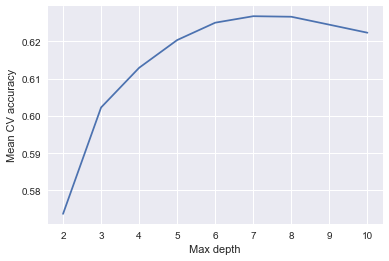

In [47]:
pony_train = test(df_2, 'win', {'win'},'formation_1','formation_2','tactics_1','tactics_2','strategy_1','strategy_2')

In [48]:
pony_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 156014 entries, 0 to 156013
Columns: 268 entries, power_1 to win
dtypes: bool(2), float64(2), int64(3), uint8(261)
memory usage: 45.1 MB


In [50]:
pony_train.head(15)

,power_1,power_2,pressure_1,pressure_2,pass_1,pass_2,formation_1_0,formation_1_1,formation_1_2,formation_1_3,...,tactics_2_100,strategy_1_0,strategy_1_1,strategy_1_2,strategy_1_3,strategy_2_0,strategy_2_1,strategy_2_2,strategy_2_3,win
0,260.4,261.9,True,True,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,-1
1,140.3,124.9,True,True,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,1
2,122.8,95.3,True,True,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
3,183.2,63.7,True,True,0,0,0,0,0,0,...,0,1,0,0,0,1,0,0,0,1
4,148.5,107.6,True,True,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,1,1
5,187.5,87.3,True,True,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
6,116.7,99.6,True,True,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,1
7,217.9,127.9,True,True,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,1
8,142.9,155.3,True,True,2,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,1
9,101.9,96.8,True,True,2,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,-1
